In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from netCDF4 import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import collections
path = os.getcwd()

* 데이터셋

In [2]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 


(119, 64, 64, 4)


In [87]:
np.random.randint(10,50,10)

array([11, 26, 16, 36, 24, 47, 38, 19, 19, 10])

* 앙상블 학습

In [88]:
class tree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        sample_ratio_by_tree: float,
        weight: float,

        input_shape: list,
        kernel_cords = None
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None

        self.sample_ratio_by_tree = sample_ratio_by_tree
        self.weight = weight

        if kernel_cords is None:
            ax1 = np.random.randint(input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
            ax2 = np.random.randint(input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
            ax3 = np.random.randint(input_shape[3], size=kernel_n).reshape(-1,1)

            self.kernel_cords = np.concatenate([ax1,ax2,ax3],axis = 1)
        else:
            self.kernel_cords = kernel_cords



    # def obj_fun_bhattacharyya_dist(self, l_values, r_values):
        

    #     l_arr = np.float32(l_values)
    #     r_arr = np.float32(r_values)

    #     max_val = np.max(np.concatenate([l_arr,r_arr]))

    #     hist_cv_l = cv2.calcHist([l_arr],[0],None,[40],[0,max_val])
    #     hist_cv_r = cv2.calcHist([r_arr],[0],None,[40] ,[0,max_val])    #[100] 빈수, [0,256]값 범위 

    #     dist = cv2.compareHist(hist_cv_l, hist_cv_r, cv2.HISTCMP_BHATTACHARYYA) #작을수록 유사도큼

    #     return dist * -1

    def obj_fun(self, l_values, r_values):
        # 고농도지점의 오차에 가중치를 더 주는 방식으로 수정할 필요가 있음

        # np.mean(y, axis = 0)
        l_mean = np.mean(l_values, axis = 0) # 0차원이 샘플수 일때
        r_mean = np.mean(r_values, axis = 0)

        l_len = len(l_values)
        r_len = len(r_values)
        # np.mean(((l_values - np.mean(l_values, axis = 0))**2)**0.5, axis = 0)
        l_sqd_error = ((l_values - np.mean(l_values, axis = 0))**2)**0.5
        
        r_sqd_error = ((r_values - np.mean(r_values, axis = 0))**2)**0.5
        

        l_weights_minmax = (l_values - np.min(l_values))/(np.max(l_values) - np.min(l_values))
        r_weights_minmax = (r_values - np.min(r_values))/(np.max(r_values) - np.min(r_values))

        l_mse = np.mean(np.mean(l_sqd_error*l_weights_minmax, axis = 0))
        r_mse = np.mean(np.mean(r_sqd_error*r_weights_minmax, axis = 0))

        mse_weighted =  (l_mse * l_len + r_mse * r_len)/(l_len + r_len)

        return mse_weighted


    def fit(self, ):
        best_score = None
        for cords in self.kernel_cords:  #컬럼_피처 루프
            
            #서브샘플로 뽑은 데이터에서만 기준을 찾고 평가는 전체 y_val에서 함으로써 과적합 가능성이 있는 피처는 거르는 효과를 기대할 수 있음
            sub_sample_ind = np.random.choice(range(len(self.x_val)),int(len(self.x_val) * self.sample_ratio_by_tree))
            val_sample_ind = np.array(list(set(list(range(len(self.x_val)))) - set(sub_sample_ind)))

            feat_data = self.x_val[sub_sample_ind,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]
            val_xdata = self.x_val[val_sample_ind,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]
            val_ydata = self.y_val[val_sample_ind]
            # feat_data = self.x_val[:,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]


            if len(set(feat_data.mean(axis = (1,2)))) == 1:

                ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
                ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
                continue
            elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
                selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            else:
                selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))

        
            # 샘플내에서 oob 검증으로 과적합 방지하기...추가
            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = val_xdata.mean(axis = (1,2)) < j

                # x_val에서 서브샘플의 값을 기준으로 정한것이지만 전체 y_val에 대해 평가함으로써 과적합 방지효과 기대
                y_left = val_ydata[left_ind]
                y_right = val_ydata[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            return None
        
                        


        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_meaned_bykernel = self.x_val[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
    
            left_ind = x_val_meaned_bykernel < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            remove_ind = collections.Counter(np.where(self.kernel_cords == self.best_feature)[0]).most_common()[0][0]
            sliced_kernels = np.delete(self.kernel_cords,remove_ind,axis = 0)

            if len(y_left) > self.minimum_sample_leaf:
                
                self.l_tree = tree(kernel_cords=sliced_kernels,max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape,sample_ratio_by_tree = self.sample_ratio_by_tree,weight=self.weight)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = tree(kernel_cords=sliced_kernels,max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape,sample_ratio_by_tree = self.sample_ratio_by_tree,weight=self.weight)
                else:
                    self.is_terminal = True
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = tree(kernel_cords=sliced_kernels,max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape,sample_ratio_by_tree = self.sample_ratio_by_tree,weight=self.weight)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = tree(kernel_cords=sliced_kernels,max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape,sample_ratio_by_tree = self.sample_ratio_by_tree,weight=self.weight)
                else:
                    self.is_terminal = True
        else:
            self.is_terminal = True


    def i_pred(self,x_data):
        if self.is_terminal:
            pred = self.y_val.mean(axis = 0)
            return pred
        
        i_x_val_meaned_bykernel = x_data[self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (0,1))
    

        if i_x_val_meaned_bykernel < self.best_feature_value:
            if self.l_tree.is_terminal:
                pred = self.l_tree.y_val.mean(axis = 0)   # 트리가 자료를 지니고있을 필요는 없음 (평균값만 저장하면 됨)
            else:
                pred = self.l_tree.i_pred(x_data)
        else:
            if self.r_tree.is_terminal:
                pred = self.r_tree.y_val.mean(axis = 0)
            else:
                pred = self.r_tree.i_pred(x_data)

        return pred.reshape(-1,self.input_shape[1],self.input_shape[2],1)

    def prediction(self, x_arr):

        if len(x_arr.shape) != 4:
            raise Exception('shape error')
        else:
        
            results = []
            for i in range(len(x_arr)):
                i_val = x_arr[i,:]
                
                result = self.i_pred(i_val)
                results.append(result)

            return results
    
    def get_tree_structure(self):
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info

In [121]:
class Gradient_boosting():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,

        sample_ratio_by_tree: float,
        n_booster: int,
        learning_rate: float,


    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

        sub_sample_ind = np.random.choice(range(len(self.x_val)),int(len(self.x_val) * 0.8))  # 서브샘플링은 트리 내에서 하고 여기서는 모든 샘플을
        
        val_ind = np.array(list(set(list(range(len(self.x_val)))) - set(list(sub_sample_ind))))
        self.x_train_data = self.x_val[sub_sample_ind]
        self.y_train_data = self.y_val[sub_sample_ind]

        self.x_val_data = self.x_val[val_ind]
        self.y_val_data = self.y_val[val_ind]


        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]
        self.sample_ratio_by_tree = sample_ratio_by_tree
        self.tree_booster = []
        self.n_booster = n_booster
        self.learning_rate = learning_rate

        self.r = 1

    def booster_prediction(self,x_vals):
        preds = np.sum([np.concatenate(ind_tree.prediction(x_vals)) * ind_tree.weight for ind_tree in self.tree_booster], axis = 0)
        return preds


    def booster_train(self,):
        
        # 이부분에서 부스터 내려갈수록 서브샘플로하게되면 계속 샘플이 적어지는효과임
        # 전체가 들어가도록하고 피팅할때 0.8만 사용하도록 수정해야함
        weight = self.learning_rate
        for i in range(self.n_booster):
            print(i)
            
            if i == 0:
                i_tree = tree(max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = self.x_train_data, y_val = self.y_train_data, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.x_train_data.shape,sample_ratio_by_tree = self.sample_ratio_by_tree,weight=weight)
                i_tree.fit()
                self.tree_booster.append(i_tree)
            else:

                y_val_sub_res = self.y_train_data - self.booster_prediction(self.x_train_data)
                i_tree = tree(max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = self.x_train_data, y_val = y_val_sub_res, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.x_train_data.shape,sample_ratio_by_tree = self.sample_ratio_by_tree,weight=weight)
                i_tree.fit()
                self.tree_booster.append(i_tree)

                print('train_loss: ', np.mean(np.abs(self.y_train_data - self.booster_prediction(self.x_train_data))), '   val_loss: ', np.mean(np.abs(self.y_val_data - self.booster_prediction(self.x_val_data))))

            # weight = weight * (1 - self.r) if weight>0.05 else 0.05
            print('가중치-- ', i_tree.weight)
    

In [97]:
test

[0, 1, 2, 3, 4]

In [122]:
booster = Gradient_boosting(max_depth=5,
                            i_depth=0,
                            minimum_sample_leaf=20,
                            y_val=y_train, # y_train
                            x_val=x_train, # x_train
                            is_terminal=False,

                            kernel_size=[5,5],
                            kernel_n=10,

                            input_shape=a.shape,

                            sample_ratio_by_tree=0.5,
                            n_booster=65,
                            learning_rate=0.3,
                            
                            )
booster.booster_train()

0
가중치--  0.3
1
train_loss:  6.181868916173407    val_loss:  6.286572769106758
가중치--  0.3
2
train_loss:  4.327308241321385    val_loss:  4.431230780681937
가중치--  0.3
3
train_loss:  3.0291365302000997    val_loss:  3.133181581615816
가중치--  0.3
4
train_loss:  2.1207110853861435    val_loss:  2.22372203155165
가중치--  0.3
5
train_loss:  1.485422444437314    val_loss:  1.587198234740837
가중치--  0.3
6
train_loss:  1.0411084867443932    val_loss:  1.1436335111000921
가중치--  0.3
7
train_loss:  0.7307678028491419    val_loss:  0.8292360908856689
가중치--  0.3
8
train_loss:  0.5139896520390014    val_loss:  0.6176123633609886
가중치--  0.3
9
train_loss:  0.363563187363674    val_loss:  0.4742002937143613
가중치--  0.3
10
train_loss:  0.26066165408464503    val_loss:  0.3809069664200326
가중치--  0.3
11
train_loss:  0.19270636483657996    val_loss:  0.32291253620883076
가중치--  0.3
12
train_loss:  0.14901617065172368    val_loss:  0.28844129869716406
가중치--  0.3
13
train_loss:  0.11933382268812524    val_loss:  0.2

0.10928918155314848


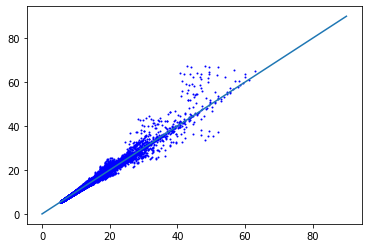

In [125]:
pred = booster.booster_prediction(x_train)
plt.plot(pred.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])
print(np.mean(np.abs(pred.reshape(-1) - y_train.reshape(-1))))

0.004377015689864597


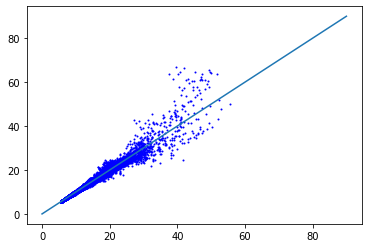

In [126]:
pred_test = booster.booster_prediction(x_test)
plt.plot(pred_test.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])
print(np.abs(np.mean(pred_test.reshape(-1) - pm2_5.reshape(-1))))

<AxesSubplot: title={'center': 'true'}>

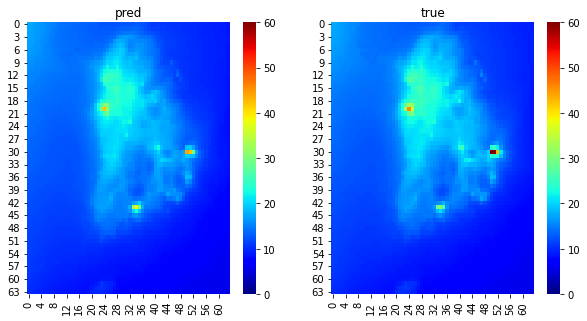

In [128]:
i = 40
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=60)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(y_train[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=60)

<AxesSubplot: title={'center': 'pred'}>

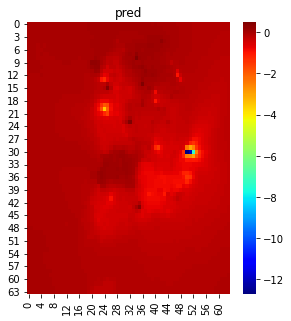

In [131]:
i = 2
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1] - y_train[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,)


<AxesSubplot: title={'center': 'true'}>

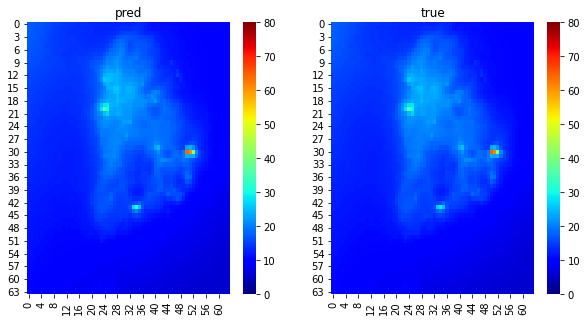

In [44]:
i = 1
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

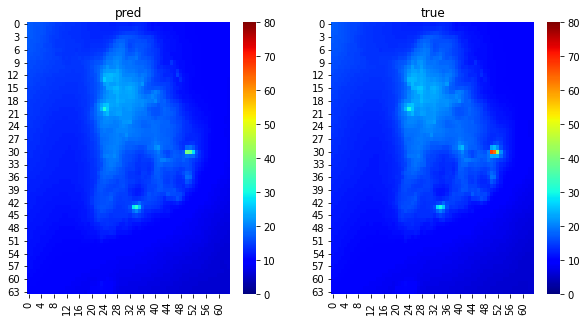

In [130]:
i = 2
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

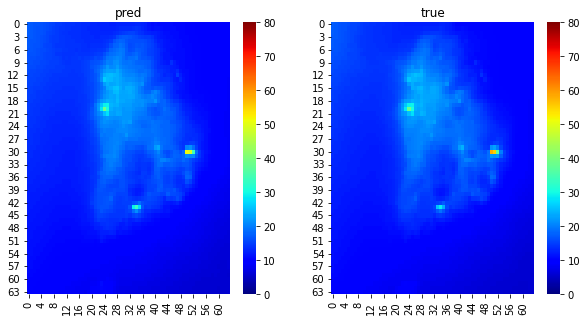

In [46]:
i = 3
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

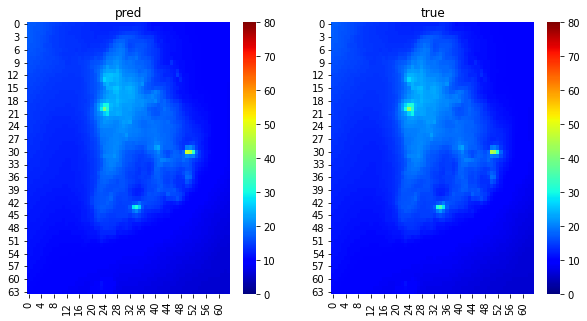

In [47]:
i = 4
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

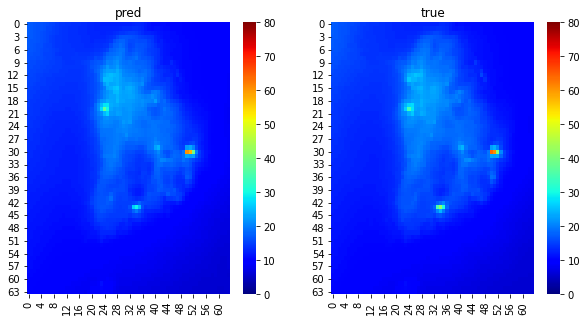

In [48]:
i = 5
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

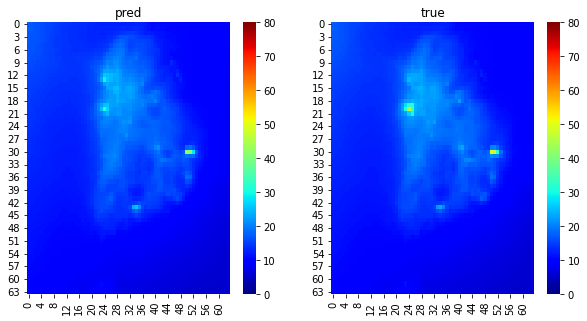

In [49]:
i = 6
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

* marginal contribution calculate